In [1]:
# This cell is not visible when the documentation is built.

import numpy as np
import pandas as pd
pd.plotting.register_matplotlib_converters()
import xarray as xr
from scipy.interpolate import interp1d
from mpl_toolkits.mplot3d import Axes3D

# time vector on 4 years
times = pd.date_range('2000-01-01', '2003-12-31', freq='D')
# temperature data as seasonal cycle -18 to 18
tas = xr.DataArray(-18 * np.cos(2 * np.pi * times.dayofyear / 365),
                   dims=('time',), coords={'time': times}, name ='tas',
                   attrs={'units': 'degC', 'standard_name': 'air_temperature', 
                          'long_name': 'Mean air temperature at surface'})

# write 10 members adding cubic-smoothed gaussian noise of wavenumber 43 and amplitude 20
# resulting temp will oscillate between -18 and 38
for i in range(10):
    tasi = tas + 20 * interp1d(np.arange(43), np.random.random((43,)), kind='quadratic')(np.linspace(0, 42, tas.size))
    tasi.name = 'tas'
    tasi.attrs.update(tas.attrs)
    tasi.attrs['title'] = f'tas of member {i:02d}'
    tasi.to_netcdf(f'ens_tas_m{i}.nc')

# Create 'toy' criteria selection data
np.random.normal(loc=3.5, scale=1.5, size=50)
#crit['delta_annual_tavg']
np.random.seed(0)
test = xr.DataArray(np.random.normal(loc=3, scale=1.5, size=100), dims=['realization']).assign_coords(horizon='2041-2070')
test = xr.concat((test,xr.DataArray(np.random.normal(loc=5.34, scale=2, size=100), dims=['realization']).assign_coords(horizon='2071-2100')), dim='horizon')

ds_crit = xr.Dataset()

ds_crit['delta_annual_tavg'] = test
test = xr.DataArray(np.random.normal(loc=5, scale=5, size=100), dims=['realization']).assign_coords(horizon='2041-2070')
test = xr.concat((test,xr.DataArray(np.random.normal(loc=10, scale=8, size=100), dims=['realization']).assign_coords(horizon='2071-2100')), dim='horizon')
ds_crit['delta_annual_prtot'] = test
test = xr.DataArray(np.random.normal(loc=0, scale=3, size=100), dims=['realization']).assign_coords(horizon='2041-2070')
test = xr.concat((test,xr.DataArray(np.random.normal(loc=2, scale=4, size=100), dims=['realization']).assign_coords(horizon='2071-2100')), dim='horizon')
ds_crit['delta_JJA_prtot'] = test

Ensembles
=========

An important aspect of climate models is that they are run multiple times with some initial perturbations to see how they replicate the natural variability of the climate. Through [xclim.ensembles](../api.rst#module-xclim.ensembles), xclim provides an easy interface to compute ensemble statistics on different members. Most methods perform checks and conversion on top of simpler `xarray` methods, providing an easier interface to use.

### create_ensemble
Our first step is to create an ensemble. This methods takes a list of files defining the same variables over the same coordinates and concatenates them into one dataset with an added dimension `realization`.

Using `xarray` a very simple way of creating an ensemble dataset would be :
```python
import xarray
xarray.open_mfdataset(files, concat_dim='realization')
```

However, this is only successful when the dimensions of all the files are identical AND only if the calendar type of each netcdf file is the same

xclim's `create_ensemble()` method overcomes these constraints selecting the common time period to all files and assigns a standard calendar type to the dataset. 

<div class="alert alert-info">

Input netcdf files still require equal spatial dimension size (e.g. lon, lat dimensions). <br>
If input data contains multiple cftime calendar types they must not be at daily frequency.

</div>

Given files all named `ens_tas_m[member number].nc`, we use `glob` to get a list of all those files.

In [2]:
import glob
import xclim as xc
import xarray as xr
# Set display to HTML sytle (for fancy output)
xr.set_options(display_style='html', display_width=50)

import matplotlib.pyplot as plt
%matplotlib inline

from xclim import ensembles

ens = ensembles.create_ensemble(glob.glob('ens_tas_m*.nc')).load()
ens.close()

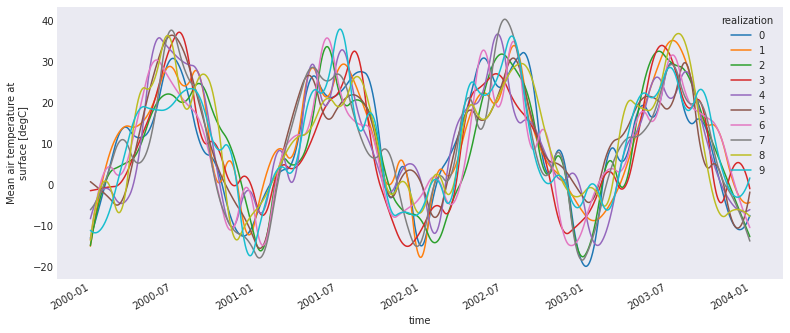

In [9]:
plt.style.use('seaborn-dark')
plt.rcParams['figure.figsize'] = (13, 5)
ens.tas.plot(hue='realization')
plt.show()

In [4]:
ens.tas  # Attributes of the first dataset to be opened are copied to the final output

<xarray.DataArray 'tas' (realization: 10, time: 1461)>
array([[-13.00233348, -12.63246594, -12.26060849, ...,  -8.0857674 ,
         -7.79646543,  -7.49312115],
       [-14.96231569, -14.26037929, -13.5664611 , ...,  -4.39108392,
         -4.33513076,  -4.26780172],
       [-14.82072608, -14.17303846, -13.53628853, ..., -12.10752014,
        -12.37538296, -12.6424643 ],
       ...,
       [ -6.09473024,  -5.96811035,  -5.8359423 , ..., -13.06057796,
        -13.39186636, -13.72596027],
       [-13.53042316, -12.67611886, -11.84765559, ...,  -7.47023191,
         -7.57900178,  -7.69159109],
       [-11.10038446, -11.21010763, -11.30888384, ...,   1.01420175,
          1.34192929,   1.6825325 ]])
Coordinates:
  * time         (time) datetime64[ns] 2000-01-...
  * realization  (realization) int64 0 1 2 ... 8 9
Attributes:
    units:          degC
    standard_name:  air_temperature
    long_name:      Mean air temperature at sur...
    title:          tas of member 02

### Ensemble statistics
Beyond creating ensemble dataset the `xclim.ensembles` module contains functions for calculating statistics between realizations

**Ensemble mean, standard-deviation, max & min**

In the example below we use xclim's `ensemble_mean_std_max_min()` to calculate statistics across the 10 realizations in our test dataset. Output variables are created combining the original variable name `tas` with addtional ending indicating the statistic calculated on the realization dimension : `_mean`, `_stdev`, `_min`, `_max`

The resulting output now contains 4 derived variables from the original single variable in our ensemble dataset.

In [5]:
ens_stats = ensembles.ensemble_mean_std_max_min(ens)
ens_stats

<xarray.Dataset>
Dimensions:    (time: 1461)
Coordinates:
  * time       (time) datetime64[ns] 2000-01-01...
Data variables:
    tas_mean   (time) float64 -9.589 ... -6.333
    tas_stdev  (time) float64 5.367 ... 4.825
    tas_max    (time) float64 0.7604 ... 1.683
    tas_min    (time) float64 -14.96 ... -13.73
Attributes:
    xclim_history:  [2020-10-21 10:48:51] : Com...

### Ensemble percentiles

Here we use xclim's `ensemble_percentiles()` to calculate percentile values across the 10 realizations. 
The output has now a `percentiles` dimension instead of `realization`. Split variables can be created instead, by specifying `split=True` (the variable name `tas` will be appended with `_p{x}`). Compared to numpy's `percentile()` and xarray's `quantile()`, this method handles more efficiently dataset with invalid values and the chunking along the realization dimension (which is automatic when dask arrays are used).

In [6]:
ens_perc = ensembles.ensemble_percentiles(ens, values=[15, 50, 85], split=False)
ens_perc

<xarray.Dataset>
Dimensions:      (percentiles: 3, time: 1461)
Coordinates:
  * time         (time) datetime64[ns] 2000-01-...
  * percentiles  (percentiles) int64 15 50 85
Data variables:
    tas          (time, percentiles) float64 -1...
Attributes:
    xclim_history:  [2020-10-21 10:48:51] : Com...

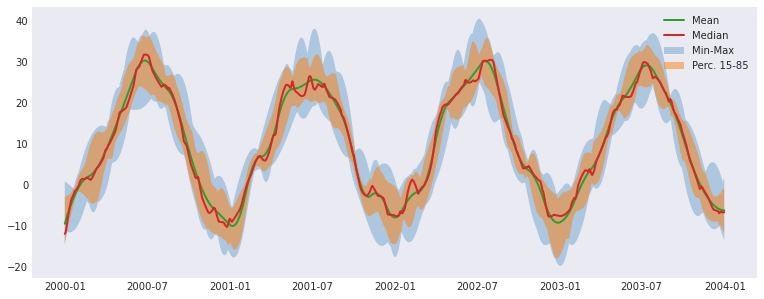

In [8]:
fig, ax = plt.subplots()
ax.fill_between(ens_stats.time.values, ens_stats.tas_min, ens_stats.tas_max, alpha=0.3, label='Min-Max')
ax.fill_between(ens_perc.time.values, ens_perc.tas.sel(percentiles=15), ens_perc.tas.sel(percentiles=85), alpha=0.5, label='Perc. 15-85')
ax._get_lines.get_next_color()  # Hack to get different line
ax._get_lines.get_next_color()
ax.plot(ens_stats.time.values, ens_stats.tas_mean, linewidth=2, label='Mean')
ax.plot(ens_perc.time.values, ens_perc.tas.sel(percentiles=50), linewidth=2, label='Median')
ax.legend()
plt.show()